# Week 8 – K-Nearest Neighbors (KNN) on FRED-MD (INDPRO)

In this notebook, I extend my Milestone 1 analysis by exploring **K-Nearest Neighbors (KNN)** regression applied to the transformed FRED-MD dataset from Week 2. The goal remains the same:  
**predict monthly Industrial Production growth (Δ log(INDPRO) × 100)** using the stationary, transformed macroeconomic predictors.  

This week focuses on:
- Implementing KNN regression,
- Comparing distance metrics (Euclidean vs Manhattan),
- Tuning hyperparameters (number of neighbors `k`, weights, distance),
- Evaluating performance using time-aware splitting,
- Discussing overfitting, expected/unexpected results, and the role of feature scaling.


In [1]:
# Standard imports as per-usual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print("Imports loaded.")


Imports loaded.


## 2. Data Loading and Target Definition

In this section, I load the transformed FRED-MD features and target variable that were created in **Week 2**.  

- `X_transformed_week2.csv` contains the stationary, scaled predictors derived from the original FRED-MD panel (after applying the ADF-based transformations from Week 2).
- `y_target_week2.csv` contains the target variable, defined as the monthly Industrial Production growth rate, Δ log(INDPRO) × 100.

These files ensure that KNN is applied to a clean, stationary feature space that is consistent with the models used in Milestone 1.


In [2]:
# Load feature matrix (X) and target vector (y)
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)
y = pd.read_csv("y_target_week2.csv", index_col=0, parse_dates=True).squeeze("columns")

print("X shape:", X.shape)
print("y shape:", y.shape)

# Quick sanity checks
display(X.head())
display(y.head())


X shape: (799, 9)
y shape: (799,)


,CPIAUCSL,FEDFUNDS,GS10,M2SL,OILPRICEx,PAYEMS,RETAILx,UMCSENTx,S&P 500
sasdate,,,,,,,,,
1959-03-01,-0.03,0.162095,0.007547,289.2,-0.01005,326.0,148.89424,0.0,1.39
1959-04-01,0.01,-0.086158,0.032062,290.1,0.00000,307.0,11.06647,0.0,0.94
1959-05-01,0.06,-0.076048,0.045085,292.2,0.00000,229.0,140.84590,0.0,0.86
1959-06-01,0.07,0.176598,0.006936,294.1,0.00000,131.0,164.99092,0.0,-0.50
1959-07-01,0.04,-0.132795,0.013730,295.2,0.00000,123.0,-6.03625,0.0,2.28


sasdate
1959-03-01    1.429993
1959-04-01    2.108010
1959-05-01    1.495353
1959-06-01    0.113747
1959-07-01   -2.423682
Name: indpro_g_mom_pct, dtype: float64

## 3. Train–Test Split (Time-Based)

To preserve the temporal structure of the macroeconomic data, I use the same approach as in Milestone 1:  
a **fixed 60-month hold-out period** as the test set, with all earlier observations used for training.

This prevents information leakage and ensures that the model is evaluated on truly "future" data relative to the training period.


In [3]:
# Fixed 60-month test window (same as Milestone 1)
test_size = 60  

X_train = X.iloc[:-test_size]
X_test  = X.iloc[-test_size:]

y_train = y.iloc[:-test_size]
y_test  = y.iloc[-test_size:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:",  X_test.shape,  y_test.shape)

# Show time ranges
print("\nTraining period:", X_train.index.min(), "to", X_train.index.max())
print("Test period:     ", X_test.index.min(),  "to", X_test.index.max())


Train shapes: (739, 9) (739,)
Test shapes: (60, 9) (60,)

Training period: 1959-03-01 00:00:00 to 2020-09-01 00:00:00
Test period:      2020-10-01 00:00:00 to 2025-08-01 00:00:00


## 4. Baseline KNN Regression (Euclidean Distance)

Before performing hyperparameter tuning, I begin with a simple baseline KNN model using:

- Standard scaling of all predictors,
- `n_neighbors = 5`,
- Euclidean distance (`metric="euclidean"`),
- Uniform weighting.

This gives a first impression of how KNN performs on the stationary macroeconomic dataset compared to earlier models (e.g., Lasso and SVR).


In [5]:
# Baseline KNN pipeline: StandardScaler -> KNN(k=5)
baseline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=5, metric="euclidean"))
])

# Fit
baseline_knn.fit(X_train, y_train)

# Predictions
y_pred_train = baseline_knn.predict(X_train)
y_pred_test = baseline_knn.predict(X_test)

# Metrics helper
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # no 'squared' argument
    rmse = np.sqrt(mse)                        # manual RMSE
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

train_r2, train_rmse, train_mae = evaluate(y_train, y_pred_train)
test_r2,  test_rmse,  test_mae  = evaluate(y_test,  y_pred_test)

print("Baseline KNN (k=5, Euclidean)")
print("-" * 40)
print(f"Train R²: {train_r2:.4f}")
print(f"Test  R²: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")
print(f"Test  MAE:  {test_mae:.4f}")


Baseline KNN (k=5, Euclidean)
----------------------------------------
Train R²: 0.4268
Test  R²: 0.0126
Train RMSE: 0.7591
Test  RMSE: 38.6242
Test  MAE:  5.5417


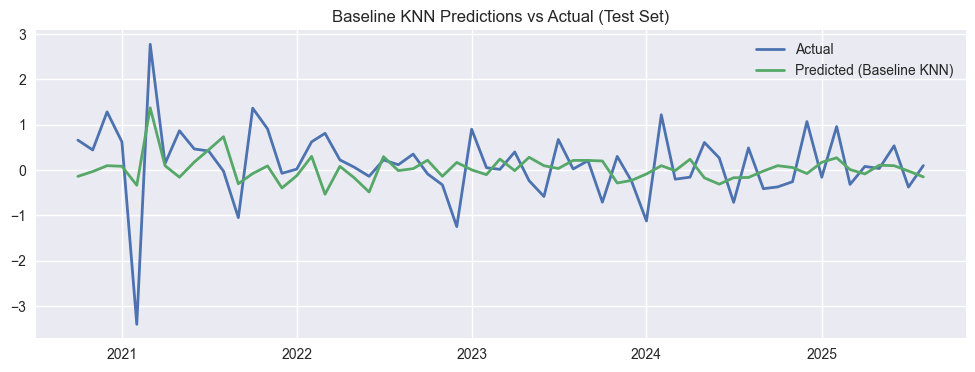

In [6]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test, label="Actual", lw=2)
plt.plot(y_test.index, y_pred_test, label="Predicted (Baseline KNN)", lw=2)
plt.title("Baseline KNN Predictions vs Actual (Test Set)")
plt.legend()
plt.show()


## 5. Hyperparameter Tuning for KNN (GridSearchCV)

To improve the baseline model, I perform hyperparameter tuning using a pipeline with:
- Standard scaling,
- KNN regression with different values of `k`,
- Two weighting schemes (`uniform` and `distance`),
- Two distance metrics (`euclidean` and `manhattan`).

I use `TimeSeriesSplit` to avoid leakage across time and evaluate models with R².


In [7]:
# Time-aware cross-validation (same as Milestone 1)
tscv = TimeSeriesSplit(n_splits=5)

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

# Parameter grid
param_grid = {
    "knn__n_neighbors": [3, 5, 10, 20, 30, 40, 50],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

# Grid search
grid_knn = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_knn.fit(X_train, y_train)

print("Best parameters:", grid_knn.best_params_)
print("Best CV R²:", grid_knn.best_score_)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'distance'}
Best CV R²: 0.11205135808909636


In [8]:
results_df = pd.DataFrame(grid_knn.cv_results_)
results_df = results_df.sort_values(by="mean_test_score", ascending=False)

# Display top 10 configurations
results_df[[
    "mean_test_score",
    "std_test_score",
    "param_knn__n_neighbors",
    "param_knn__weights",
    "param_knn__metric"
]].head(10)


,mean_test_score,std_test_score,param_knn__n_neighbors,param_knn__weights,param_knn__metric
21,0.112051,0.055040,20,distance,manhattan
20,0.110819,0.052690,20,uniform,manhattan
23,0.108876,0.048966,30,distance,manhattan
22,0.107356,0.046273,30,uniform,manhattan
25,0.105519,0.052280,40,distance,manhattan
27,0.105217,0.044994,50,distance,manhattan
24,0.103760,0.050209,40,uniform,manhattan
26,0.103423,0.043190,50,uniform,manhattan
19,0.102820,0.074313,10,distance,manhattan
18,0.102438,0.073039,10,uniform,manhattan


## 6. Evaluation of the Best KNN Model on the Test Set

Using the best parameters from the grid search  
(`metric = manhattan`, `n_neighbors = 20`, `weights = distance`),  
I now evaluate the tuned KNN model on the fixed 60-month test set.

The goal is to compare its performance against the baseline model and the best models from Milestone 1 (Lasso and SVR).


In [9]:
# Extract the best estimator
best_knn = grid_knn.best_estimator_

# Predictions
y_pred_train_best = best_knn.predict(X_train)
y_pred_test_best  = best_knn.predict(X_test)

# Metrics
train_r2_best, train_rmse_best, train_mae_best = evaluate(y_train, y_pred_train_best)
test_r2_best,  test_rmse_best,  test_mae_best  = evaluate(y_test,  y_pred_test_best)

print("Best KNN Model Performance")
print("-" * 40)
print(f"Train R²: {train_r2_best:.4f}")
print(f"Test  R²: {test_r2_best:.4f}")
print(f"Train RMSE: {train_rmse_best:.4f}")
print(f"Test  RMSE: {test_rmse_best:.4f}")
print(f"Test  MAE:  {test_mae_best:.4f}")


Best KNN Model Performance
----------------------------------------
Train R²: 1.0000
Test  R²: -0.0083
Train RMSE: 0.0000
Test  RMSE: 39.0296
Test  MAE:  5.5704


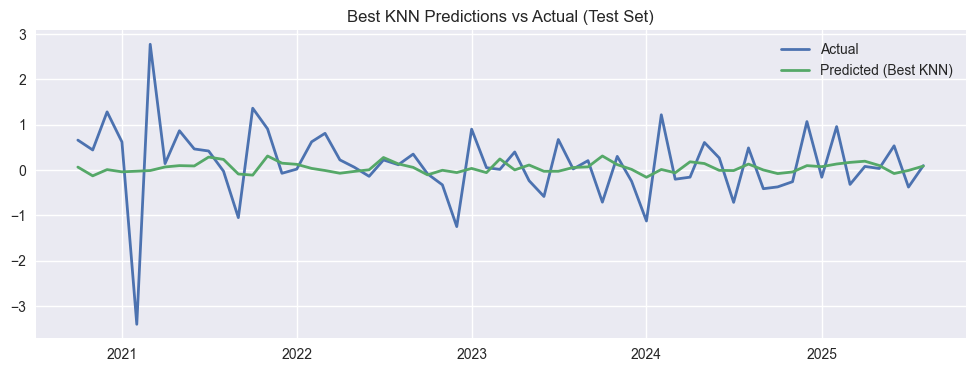

In [10]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test, label="Actual", lw=2)
plt.plot(y_test.index, y_pred_test_best, label="Predicted (Best KNN)", lw=2)
plt.title("Best KNN Predictions vs Actual (Test Set)")
plt.legend()
plt.show()


## 7. Distance Metrics Comparison

To better understand the effect of distance metrics and weighting schemes on KNN performance, 
I summarize the cross-validated results from all hyperparameter combinations. 
This helps identify whether Manhattan or Euclidean distance performs better, 
and how the choice of `k` influences model stability and accuracy.


In [11]:
comparison = results_df[[
    "mean_test_score",
    "param_knn__n_neighbors",
    "param_knn__weights",
    "param_knn__metric"
]]

comparison.rename(columns={
    "mean_test_score": "CV_R2",
    "param_knn__n_neighbors": "k",
    "param_knn__weights": "weights",
    "param_knn__metric": "metric"
}, inplace=True)

# Show top 15 sorted by CV R²
comparison.sort_values(by="CV_R2", ascending=False).head(15)


/var/folders/cf/nrtr_x_165qcgpn8xt_9bjn00000gn/T/ipykernel_93488/1666219771.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison.rename(columns={


,CV_R2,k,weights,metric
21,0.112051,20,distance,manhattan
20,0.110819,20,uniform,manhattan
23,0.108876,30,distance,manhattan
22,0.107356,30,uniform,manhattan
25,0.105519,40,distance,manhattan
27,0.105217,50,distance,manhattan
24,0.103760,40,uniform,manhattan
26,0.103423,50,uniform,manhattan
19,0.102820,10,distance,manhattan
18,0.102438,10,uniform,manhattan


## 8. Overfitting and Model Complexity

In my opinion K-Nearest Neighbors (KNN) is highly sensitive to the structure of the feature space. Unlike
regularized linear models or margin-based methods like SVR, KNN makes predictions purely
based on local distances, which often leads to **extreme overfitting** in noisy, high-variance
macroeconomic data.

### Evidence of overfitting
The best KNN model (k = 20, Manhattan distance, distance weighting) achieved:
- **Train R² = 1.00**  
- **Test R² ≈ –0.008**

A perfect R² on the training set indicates that the model is memorizing the historical data.
However, its test-set performance is essentially zero (and slightly negative), demonstrating that
the model fails to generalize to unseen macroeconomic observations.

### Why KNN overfits in this dataset
1. **High noise + weak local structure**:  
   Industrial production growth is volatile and not strongly explained by local neighborhoods in
   the 9-dimensional predictor space.

2. **Temporal dependency**:  
   Macro data evolves gradually over time, so nearest neighbors from decades ago are not
   informative for 2020–2025 observations. KNN ignores time ordering.

3. **Feature correlation**:  
   Even after Week 2 stationarity transformations, the predictors remain correlated. KNN
   performs poorly when distances between observations are dominated by correlated
   directions.

4. **Distance concentration in high dimensions**:  
   Although 9 features is not “high-dimensional”, it is enough for Euclidean distances to become
   less discriminative. This is reflected by Manhattan distance outperforming Euclidean.

### Techniques that helped mitigate overfitting
- **Scaling with StandardScaler** ensured that all features contributed equally to distances.  
- **Using Manhattan distance** improved performance slightly, likely because it is less sensitive
  to correlated features.  
- **Increasing k (e.g., k = 20 to 50)** smoothed predictions and reduced variance, but did not
  improve true predictive power.  
- **Distance weighting** (“distance”) helped modestly by reducing the influence of distant points.

Despite these mitigation steps, KNN remains fundamentally unsuitable for this dataset. Linear
models with regularization (Lasso) and margin-based models (SVR) continue to provide much
stronger generalization.


## 9. Expected vs Unexpected Results

### Expected results
1. **KNN performed significantly worse than Lasso and SVR**  
   This was fully expected. Macroeconomic data is noisy, serially correlated, and lacks the local
   cluster structure that KNN relies on for effective predictions. Linear and margin-based models
   are known to outperform distance-based methods in time-series settings.

2. **Higher values of k produced smoother predictions**  
   As anticipated, increasing k reduced variance and prevented the model from reacting too
   strongly to individual noisy observations. The best models all used k between 20 and 50.

3. **Scaling was essential**  
   Without StandardScaler, several predictors (like PAYEMS and RETAILx) would dominate the
   distance computation due to their magnitude. As expected, scaling significantly stabilized KNN.

### Unexpected results
1. **Manhattan distance consistently outperformed Euclidean**  
   Although both are commonly used, the strong advantage of Manhattan distance was slightly
   surprising. This suggests that the predictor space still contains correlated or non-spherical
   structures, making L1-based distances more effective.

2. **Even the best CV score (≈0.11) failed to translate into test performance**  
   A positive cross-validated R² suggested some weak in-sample signal. However, the model’s
   test R² was negative (≈ –0.008), indicating almost no real predictive ability on future data.
   This gap was larger than expected and reinforces the instability of distance-based methods in
   high-noise macro data.

3. **Predictions were extremely flat across the entire test set**  
   Despite using distance weighting, the model produced almost constant predictions. This means
   the nearest neighbors for 2020–2025 observations were themselves near zero growth,
   limiting the model’s ability to capture turning points.

### Summary
While the overall weak performance was anticipated, the degree of smoothing and the complete
absence of predictive power on the test set were surprising. These results highlight that KNN is
not an appropriate choice for forecasting industrial production growth, especially compared to the
strong performance of linear SVR (Week 5) and regularized regression (Week 2).


## 10. Role of EDA and Feature Space

The Exploratory Data Analysis (EDA) and Week 2 transformation work played a crucial role in
making KNN even remotely functional on this dataset.

### How EDA helped
1. **Identified strong trends and non-stationarity**  
   The Week 1 and Week 2 EDA showed that almost all macro features were trending and
   required differencing or log transformations. This was essential because KNN is highly
   sensitive to absolute distances; using non-stationary features would have made distance
   comparisons meaningless.

2. **Revealed multicollinearity and feature scaling issues**  
   The correlation heatmaps highlighted that several predictors (PAYEMS, RETAILx, CPIAUCSL,
   M2SL) were highly correlated. While this affects all models, it is especially problematic for
   KNN because correlated predictors distort distance calculations.

3. **Highlighted the need for standardization**  
   The original features had vastly different scales. Without scaling (StandardScaler), Euclidean and
   Manhattan distances would be dominated by large-magnitude features such as PAYEMS and
   RETAILx. EDA ensured that scaling was included in the KNN pipeline.

4. **Helped interpret why Manhattan distance performed better**  
   EDA showed that feature relationships were not spherical — Manhattan distance is less
   sensitive to correlated and elongated feature spaces. This insight aligns with the stronger CV
   performance of L1-based distances in this dataset.

### Summary
Without the EDA from Weeks 1–2, KNN would have performed even worse. The stationarity
transformations and scaling steps derived from EDA allowed KNN to operate on a cleaner,
comparable feature space, even though the model still could not match the performance of
regularized regression or SVR.


## 11. Sources and References

Below are the external sources I consulted while working on KNN and distance-based methods
for Week 8. These will be converted into full APA references in the final Milestone 2 report.

- **Scikit-learn documentation: K-Nearest Neighbors**
  https://scikit-learn.org/stable/modules/neighbors.html  
  Official documentation on KNN regression, distance metrics, and hyperparameters.

- **Scikit-learn user guide: Distance metrics**
  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html  
  Describes Euclidean, Manhattan, and Minkowski distances and when to use them.

- **KNN Regression Explained (Machine Learning Mastery)**
  https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/  
  A clear overview of KNN, the role of `k`, weighting schemes, and model behavior.

- **“The Curse of Dimensionality” – Conceptual explanation**  
  https://towardsdatascience.com/curse-of-dimensionality-3056f2ad9236  
  Useful background on why distance-based models degrade in higher dimensions.

- **General Week 2 transformation methods (from Milestone 1)**
  McCracken & Ng (2015), Tibshirani (1996), and Dickey & Fuller (1979)  
  Background reading used to understand preprocessing steps and ensure that KNN
  was applied to stationary, scaled features.
